In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt

os.makedirs('output_HCU', exist_ok=True)
os.makedirs('images', exist_ok=True)

#HOME = os.getenv("HOME")

In [2]:
# Function to set elements in bold
def set_bold_properties(ax):
	ax.title.set_weight('bold')
	ax.xaxis.label.set_weight('bold')
	ax.yaxis.label.set_weight('bold')
	plt.setp(ax.get_xticklabels(), weight='bold')
	plt.setp(ax.get_yticklabels(), weight='bold')

In [3]:
import pandas as pd

# Path to the uploaded file
data_path = os.path.join("input/dicom_headers_COVIDS.csv")

# Reading the CSV file and converting it into a DataFrame
df = pd.read_csv(data_path)

# Removing whitespace from column names
df.columns = df.columns.str.strip()

#print(df.columns.tolist())

df.head()

,ID,StudyDate,Acquisition date,SliceThickness,Spacing,KVP,Kernel,ExposureTime,Exposure,XRayTubeCurrent,Manufacturer,Model,Sex,Age,Protocol,Series Description,StudyDescription
0,locca_covid_001,20200723,2020-07-23,1.0,0.782 x 0.782,120.0,FC51,600,154,257,TOSHIBA,Aquilion,F,30,THORAX WITH CONTRAST,Lung 1.0 WITH CE CONTRAST,THORAX to THIGHS
1,locca_covid_002,20200728,2020-07-28,1.0,0.766 x 0.766,120.0,FC86,500,220,440,TOSHIBA,Aquilion,F,69,HIGH-RESOLUTION THORAX,Lung 1.0 INSPIRATION,THORAX AR
2,locca_covid_003,20200720,2020-07-20,1.0,0.744 x 0.744,120.0,FC86,500,215,431,TOSHIBA,Aquilion,F,54,HIGH-RESOLUTION THORAX,Lung 1.0 INSPIRATION,THORAX
3,locca_covid_004,20200708,2020-07-08,1.0,0.714 x 0.714,120.0,FC86,500,144,288,TOSHIBA,Aquilion,M,69,HIGH-RESOLUTION THORAX,Lung 1.0 INSPIRATION,NaN
4,locca_covid_005,20200702,2020-07-02,0.5,0.793 x 0.793,120.0,FC86,400,200,500,TOSHIBA,Aquilion,F,75,HIGH-RESOLUTION THORAX,Lung 0.5 EXPIRATION,CT TX AR


## Checking sex and age

In [4]:
# Obtaining the minimum and maximum value of a specific column
min_val = df['Age'].min()
max_val = df['Age'].max()

print("Minimum age:", min_val)
print("Maximum age:", max_val)


df['Age'] = df['Age'].fillna(0).astype(int)


# Calculating the mean of ages
average_ages = df['Age'].mean()

# Calculating the standard deviation of ages
ages_std = df['Age'].std()

print('Average age:', average_ages)
print('Standard deviation:', ages_std)


# Obtaining the minimum and maximum value of a specific column
min_val = df['StudyDate'].min()
max_val = df['StudyDate'].max()

print("Minimum StudyDate:", min_val)
print("Maximum StudyDate:", max_val)


# Getting the minimum and maximum value of a specific column
min_val = df['Acquisition date'].min()
max_val = df['Acquisition date'].max()

print("Minimum date:", min_val)
print("Maximum date:", max_val)

# Filter and count people with sex "M"
male_count = df[df['Sex'] == 'M'].shape[0]
female_count = df[df['Sex'] == 'F'].shape[0]

print(f"Number of males: {male_count}")
print(f"Number of females: {female_count}")

Minimum age: 30
Maximum age: 96
Average age: 60.9
Standard deviation: 14.739929349945315
Minimum StudyDate: 20200401
Maximum StudyDate: 20200911
Minimum date: 2020-04-01
Maximum date: 2020-09-11
Number of males: 13
Number of females: 17


In [5]:
# Define the age groups
bins = [0, 10, 20, 30, 40, 50, 60, float('inf')]  # Range limits
labels = ['Less than 10', 'Between 10 e 20', 'Between 20 e 30',
		  'Between 30 e 40', 'Between 40 e 50', 'Between 50 e 60', 'Greater than 60']

# Converter a coluna para int, substituindo valores inválidos por NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Fill NaN with a default value (optional)
df['Age'] = df['Age'].fillna(0).astype(int)

# Categorize the ages
df['Range_Limits'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Count the number of people in each age group
age_group_counts = df['Range_Limits'].value_counts()

#print(df)
print("\nCount of people by age group:")
print(age_group_counts)


Count of people by age group:
Range_Limits
Greater than 60    17
Between 50 e 60     7
Between 40 e 50     4
Between 30 e 40     2
Less than 10        0
Between 10 e 20     0
Between 20 e 30     0
Name: count, dtype: int64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


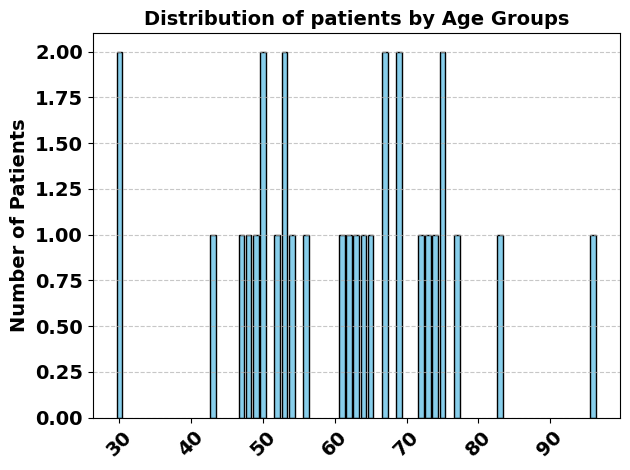

In [6]:
# Count the number of people in each age group
age_group_counts = df['Age'].value_counts().sort_index()

# Plot the bar chart
plt.bar(age_group_counts.index, age_group_counts.values, color='skyblue', edgecolor='black')

# Chart settings
plt.title('Distribution of patients by Age Groups', fontsize=14, fontweight='bold')
plt.ylabel('Number of Patients', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.tight_layout()
plt.savefig("images/distribuition_patientes_age_groups.eps", dpi=200, format='eps')
#plt.savefig("images/distribuition_patientes_age_groups.png", transparent=True, dpi=300, format='png')
plt.show()

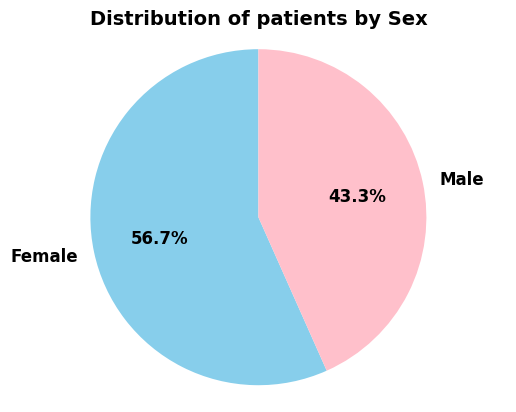

In [7]:
# Replace 'F' with 'Female' and 'M' with 'Male' in the 'Sex' column
df['Sex'] = df['Sex'].replace({'F': 'Female', 'M': 'Male'})

# Count the number of people by sex
sex_counts = df['Sex'].value_counts()

# Create the pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
	sex_counts,
	labels=sex_counts.index,
	autopct='%1.1f%%',
	startangle=90,
	colors=['skyblue', 'pink'],
	textprops={'fontweight': 'bold', 'fontsize': 12}
)

# Set up the texts inside the sectors (autotexts)
for autotext in autotexts:
	autotext.set_fontweight('bold')
	autotext.set_color('black')
	autotext.set_fontsize(12)

# Chart settings
ax.set_title('Distribution of patients by Sex', fontsize=14, fontweight='bold')
ax.axis('equal')  # Ensure that the chart is circular.

plt.savefig("images/sex.eps", dpi=200, format='eps')

# Display the chart
plt.show()

In [8]:
import pandas as pd

# Path to the file
data_file_path = os.path.join("input/dados_images_hcu.csv")

# Reading the CSV file and converting it into a DataFrame
df_csv_data = pd.read_csv(data_file_path)

# Removing whitespace from column names
df_csv_data.columns = df_csv_data.columns.str.strip()

df_csv_data.rename(columns={'ID_image': 'ID'}, inplace=True)

df_csv_data['LUL'] = df_csv_data['LUL'].astype(float)
df_csv_data['LLL'] = df_csv_data['LLL'].astype(float)
df_csv_data['RUL'] = df_csv_data['RUL'].astype(float)
df_csv_data['RML'] = df_csv_data['RML'].astype(float)
df_csv_data['RLL'] = df_csv_data['RLL'].astype(float)

#print(df_csv_data.columns.tolist())

df = pd.merge(df, df_csv_data[['ID', 'LUL']], on='ID')
df = pd.merge(df, df_csv_data[['ID', 'LLL']], on='ID')
df = pd.merge(df, df_csv_data[['ID', 'RUL']], on='ID')
df = pd.merge(df, df_csv_data[['ID', 'RML']], on='ID')
df = pd.merge(df, df_csv_data[['ID', 'RLL']], on='ID')

# Displaying the first rows of the table
#print(df_csv_data.head())

In [9]:
#print(df.head())
print('Number of images in the dataset:', df['ID'].count())

Number of images in the dataset: 30


## Checking findings

In [10]:
import pandas as pd

# Path to the file
file_path = os.path.join("input/medseg_run_statistics_hcu.csv")

# Reading the CSV file and converting it into a DataFrame
df_csv = pd.read_csv(file_path)

# Merging the column 'POI (%)' from table B into table A based on the 'id' column
df_sorted = pd.merge(df, df_csv[['ID', 'POI (%)']], on='ID')
df_sorted = pd.merge(df_sorted, df_csv[['ID', 'Voxel volume (mm³)']], on='ID')

#output_csv = "output_HCU/dicom_headers_COVIDS_POI.csv"
#df_sorted.to_csv(output_csv, index=False)
#print(f"Tabela salva em {output_csv}")

In [11]:
# Defining the ranges for categorization
bins = [-float('inf'),1,5,25,50,75,float('inf')]
labels = [0,1,2,3,4,5]

df_sorted['LUL'] = df_sorted['LUL']*100
df_sorted['LLL'] = df_sorted['LLL']*100
df_sorted['RUL'] = df_sorted['RUL']*100
df_sorted['RML'] = df_sorted['RML']*100
df_sorted['RLL'] = df_sorted['RLL']*100

lobes = ['LUL','LLL','RUL','RML','RLL']

for lobe in lobes:
	# Creating a new column with the categories
	df_sorted['PI_'+str(lobe)] = pd.cut(df_sorted[lobe],
						bins=bins,
						labels=labels,
						include_lowest=True)

	# Sorting the DataFrame first by category and then by the findings value
	df_sorted = df_sorted.sort_values(['PI_'+str(lobe), lobe])

	# Calculating statistics by category
	category_statistics = df_sorted.groupby('PI_'+str(lobe), observed=False).agg({
		lobe: ['count', 'mean', 'min', 'max']
	}).round(2)

	# Resetting the index for better visualization
	df_sorted = df_sorted.reset_index(drop=True)

	#print("Original DataFrame Categorized and Sorted:")
	#print(df_sorted)
	#print("\nStatistics by PI:")
	#print(category_statistics)

df_sorted['PI_LUL'] = df_sorted['PI_LUL'].astype(float)
df_sorted['PI_LLL'] = df_sorted['PI_LLL'].astype(float)
df_sorted['PI_RUL'] = df_sorted['PI_RUL'].astype(float)
df_sorted['PI_RML'] = df_sorted['PI_RML'].astype(float)
df_sorted['PI_RLL'] = df_sorted['PI_RLL'].astype(float)

df_sorted['Score'] = df_sorted[['PI_LUL', 'PI_LLL', 'PI_RUL', 'PI_RML', 'PI_RLL']].sum(axis=1)

# Defining the intervals for categorization
bins_score = [-1, 0, 7, 17, float('inf')]
labels_score = ['No Lesion', 'Mild', 'Moderate', 'Severe']

# Creating a new column with the categories
df_sorted['CategoryScore'] = pd.cut(df_sorted['Score'],
						bins=bins_score,
						labels=labels_score,
						include_lowest=True)

# Sorting the DataFrame first by category and then by the findings value
df_sorted = df_sorted.sort_values(['CategoryScore', 'Score'])

# Calculating statistics by category
category_statistics = df_sorted.groupby('CategoryScore', observed=False).agg({
	'Score': ['count', 'mean', 'min', 'max']
}).round(2)

# Resetting the index for better visualization
df_sorted = df_sorted.reset_index(drop=True)

#print("Categorized and Sorted Original DataFrame:")
#print(df_sorted)
print("\nStatistics by CategoryScore:")
print(category_statistics)

# Example of how to filter by a specific category
specific_category = df_sorted[df_sorted['CategoryScore'] == 'Severe']
#print("\nRecords in the critical category:")
#print(specific_category)


Statistics by CategoryScore:
              Score                   
              count   mean   min   max
CategoryScore                         
No Lesion         2   0.00   0.0   0.0
Mild              6   5.17   3.0   6.0
Moderate         17  11.18   8.0  17.0
Severe            5  19.00  18.0  21.0


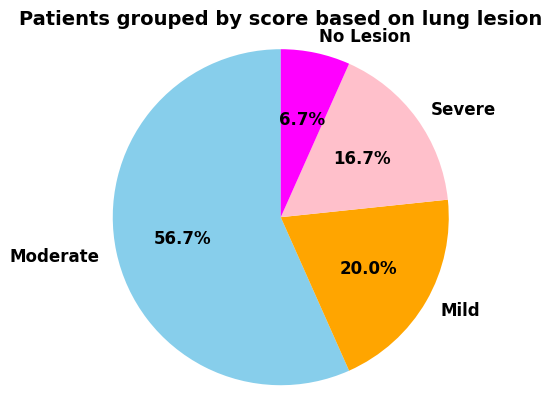

In [12]:
# Count the number of patients grouped by score
categoriaScore_counts = df_sorted['CategoryScore'].value_counts()

# Remove empty categories (NaN or zero values)
categoriaScore_counts = categoriaScore_counts[categoriaScore_counts > 0]

# Create the pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
	categoriaScore_counts,
	labels=categoriaScore_counts.index,
	autopct='%1.1f%%',
	startangle=90,
	colors=['skyblue', 'orange', 'pink', 'magenta'],
	textprops={'fontweight': 'bold', 'fontsize': 12}
)

# Set the texts inside the sectors (autotexts)
for autotext in autotexts:
	autotext.set_fontweight('bold')
	autotext.set_color('black')
	autotext.set_fontsize(12)

# Chart settings
ax.set_title('Patients grouped by score based on lung lesion', fontsize=14, fontweight='bold')
ax.axis('equal')  # Ensure the chart is circular

plt.savefig("images/patientes_grouped_score_hcu.eps", dpi=200, format='eps')

# Display the chart
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


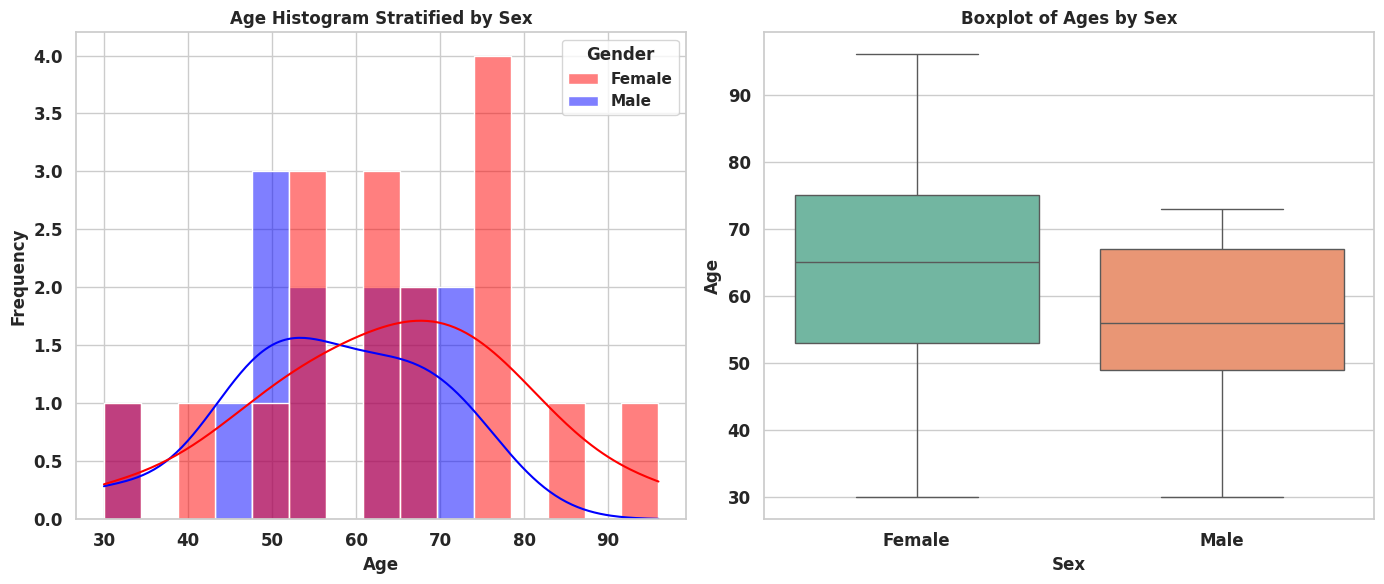

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = df_sorted.copy(deep=True)
df['Sex'] = df['Sex'].replace({'F': 'Female', 'M': 'Male'})

# Chart style settings
sns.set_theme(style="whitegrid")

# Creating the charts side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram stratified by sex
sns.histplot(data=df, x="Age", hue="Sex", kde=True, ax=axes[0], bins=15, palette={'Male': 'blue', 'Female': 'red'})

# Bold title and labels for the first chart
# A histogram with kernel density estimate (KDE) for each sex
axes[0].set_title("Age Histogram Stratified by Sex", fontweight='bold')
axes[0].set_xlabel("Age", fontweight='bold')
axes[0].set_ylabel("Frequency", fontweight='bold')

# Setting the legend in bold
legend = axes[0].get_legend()
if legend:
	legend.set_title("Gender", prop={"weight": "bold", "size": 12})
	for text in legend.get_texts():
		text.set_fontweight('bold')

# Setting bold ticks for the first chart
for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
	label.set_fontweight('bold')
	label.set_fontsize(12)

# Boxplot stratified by sex
sns.boxplot(data=df, x="Sex", y="Age", palette="Set2", ax=axes[1], hue="Sex")

# Bold title and labels for the second chart
axes[1].set_title("Boxplot of Ages by Sex", fontweight='bold')
axes[1].set_xlabel("Sex", fontweight='bold')
axes[1].set_ylabel("Age", fontweight='bold')

# Bold tick configuration for the second chart
for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
	label.set_fontweight('bold')
	label.set_fontsize(12)

# Layout adjustment
plt.tight_layout()
plt.savefig("images/age_sex.eps", dpi=200, format='eps')
plt.show()

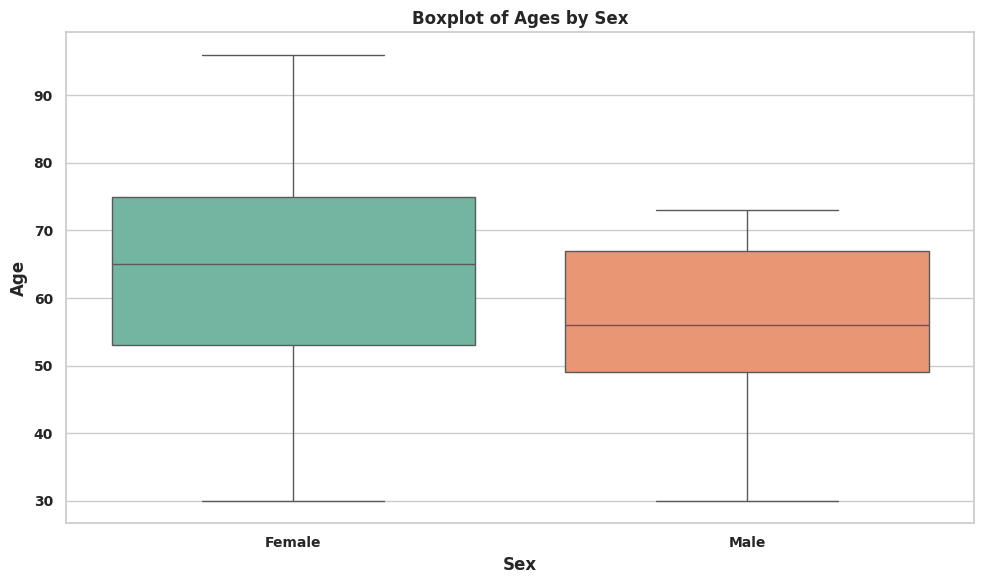

In [14]:
# Boxplot stratified by sex
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Sex", y="Age", palette="Set2", hue="Sex")

# Bold title and labels for the chart
plt.title("Boxplot of Ages by Sex", fontweight='bold')
plt.xlabel("Sex", fontweight='bold')
plt.ylabel("Age", fontweight='bold')

plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Layout adjustment
plt.tight_layout()
plt.savefig("images/age_sex2.eps", dpi=200, format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


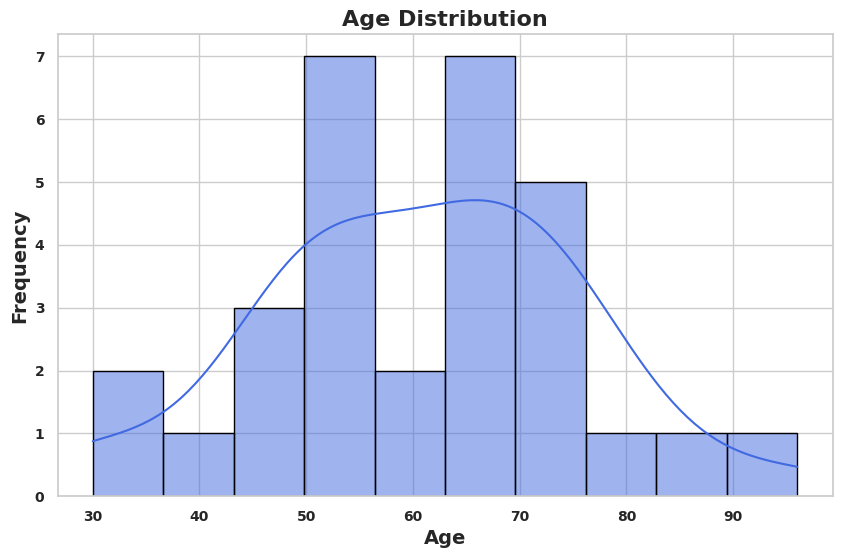

In [15]:
sns.set_theme(style="whitegrid")

# Create the histogram of ages
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=10, kde=True, color='royalblue', edgecolor='black')

# Set the chart labels and title
plt.title('Age Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

plt.savefig("images/hist_age.eps", dpi=200, format='eps')

# Display the chart
plt.show()

In [16]:
# Merging the column 'Spacing' from table B into table A based on the 'ID' column
df_sorted = pd.merge(df_sorted, df_csv_data[['ID', 'Spacing']], on='ID')

df_sorted = df_sorted.drop(columns=['Acquisition date'])
df_sorted = df_sorted.drop(columns=['PI_LUL', 'PI_LLL', 'PI_RUL', 'PI_RML', 'PI_RLL'])

df_sorted.rename(columns={'ID': 'ID Image'}, inplace=True)

#print(df_sorted.columns.tolist())

output_csv = "output_HCU/dicom_headers_COVIDS_final.csv"
df_sorted.to_csv(output_csv, index=False)
print(f"Tble saved in {output_csv}")

Tble saved in output_HCU/dicom_headers_COVIDS_final.csv


## Additional information

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


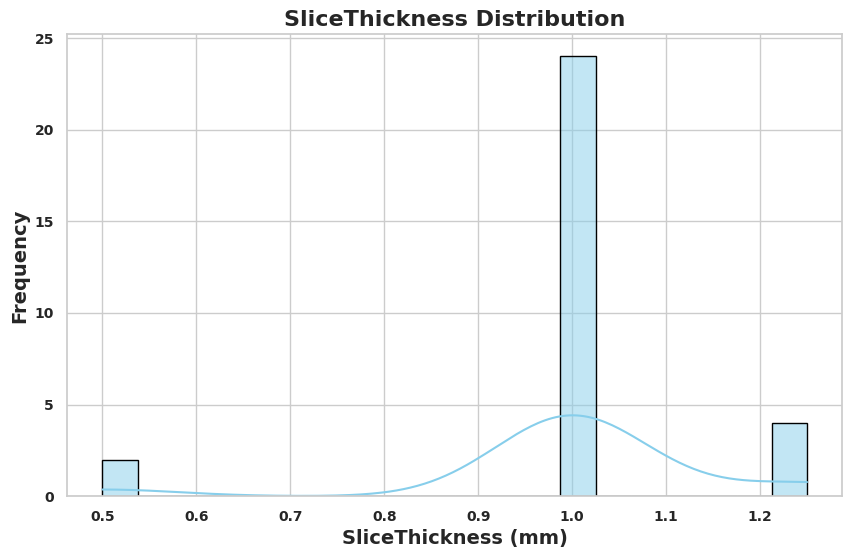

In [17]:
data = df_sorted.copy(deep=True)

# Setting the style of the charts
sns.set_theme(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['SliceThickness'], bins=20, kde=True, color='skyblue', edgecolor='black')

# Set the chart labels and title
plt.title('SliceThickness Distribution', fontsize=16, fontweight='bold')
plt.xlabel('SliceThickness (mm)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

plt.savefig("images/sliceThickness.eps", dpi=200, format='eps')

# Display the chart
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


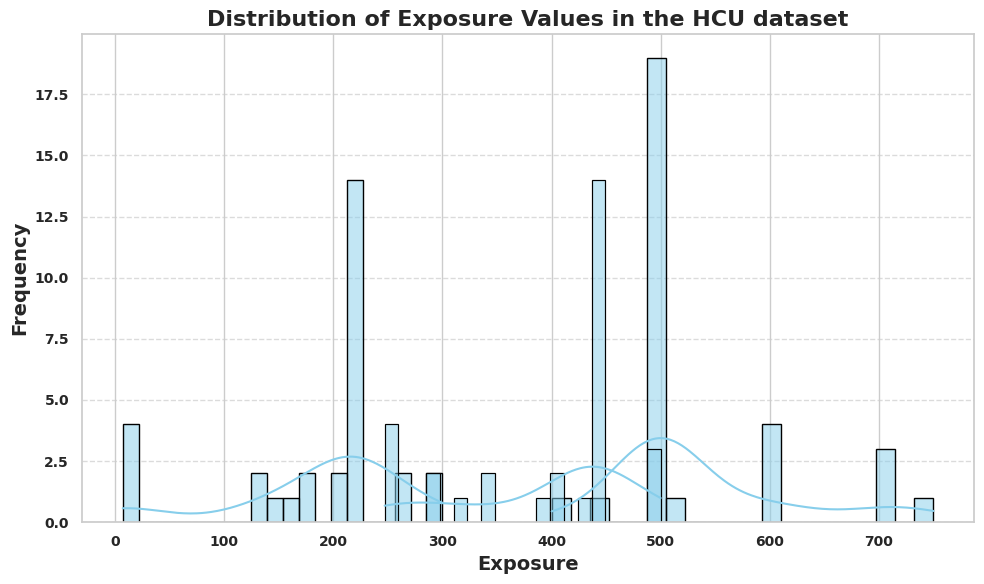

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = df_sorted.copy(deep=True)

# Configure the chart with Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df_sorted['Exposure'], kde=True, bins=20, color='skyblue', edgecolor='black')
sns.histplot(df_sorted['ExposureTime'], kde=True, bins=20, color='skyblue', edgecolor='black')
sns.histplot(df_sorted['XRayTubeCurrent'], kde=True, bins=20, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Exposure Values in the HCU dataset', fontsize=16, fontweight='bold')
plt.xlabel('Exposure', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.tight_layout()
plt.savefig("images/exposure.eps", dpi=200, format='eps')
plt.show()

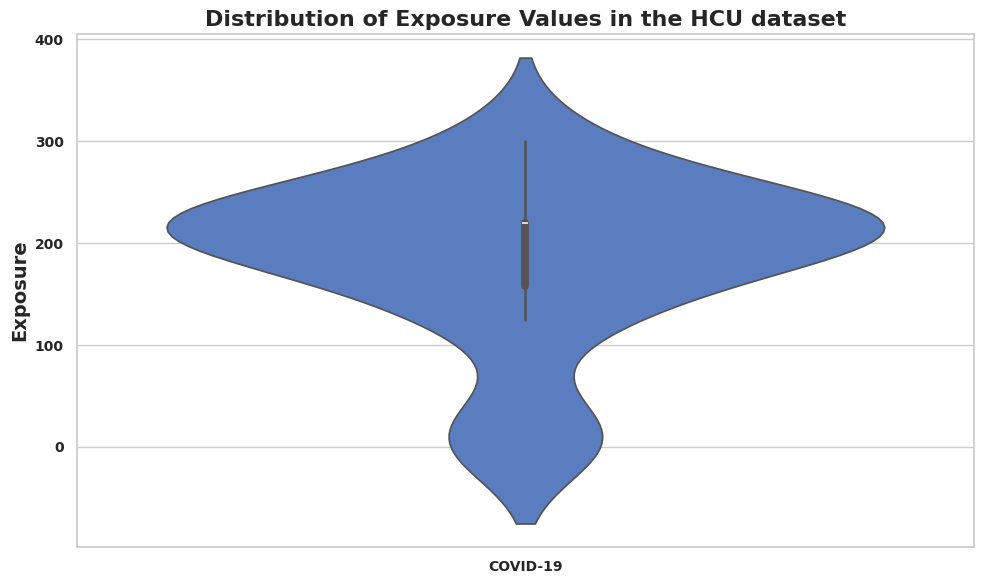

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a fictitious dataset
np.random.seed(42)
data = {
	'Exposure': df_sorted['Exposure'],
	'Group': np.random.choice(['COVID-19'], size=df_sorted['Exposure'].count())
}

df = pd.DataFrame(data)

# Configure the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Group', y='Exposure', data=df, hue='Group', palette='muted', legend=False)

# Add titles and labels
plt.title('Distribution of Exposure Values in the HCU dataset', fontsize=16, fontweight='bold')
plt.xlabel(None, fontsize=14, fontweight='bold')
plt.ylabel('Exposure', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Display the chart
plt.tight_layout()
plt.savefig("images/exposure2.eps", dpi=200, format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


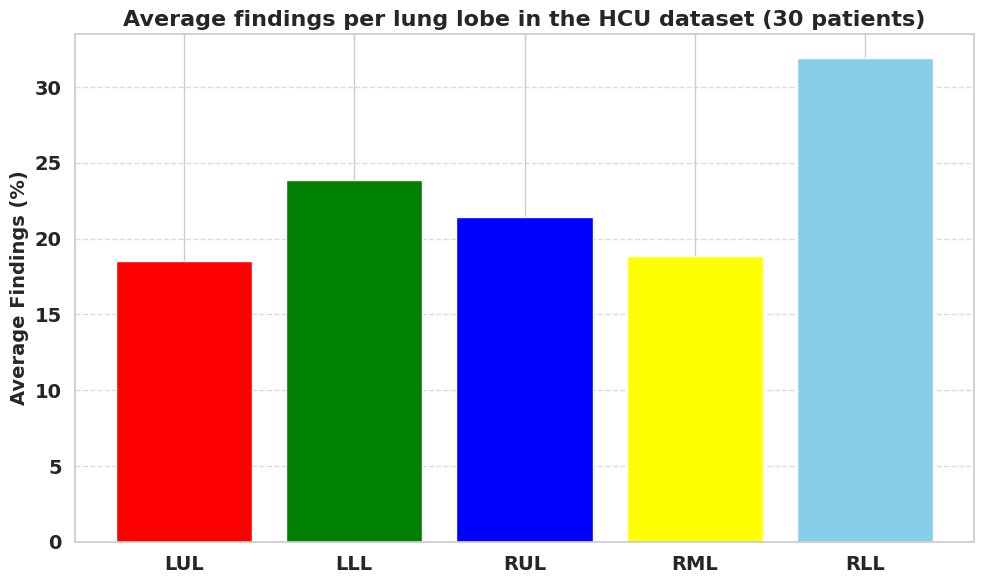

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of the findings per lobe
lobos = ['LUL', 'LLL', 'RUL', 'RML', 'RLL']
average_findings = df_sorted[lobos].mean()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_findings.index, average_findings, color=['red', 'green', 'blue', 'yellow', 'skyblue'])

# Customize the chart
plt.title('Average findings per lung lobe in the HCU dataset (30 patients)', fontsize=16, fontweight='bold')
plt.ylabel('Average Findings (%)', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Display the chart
plt.tight_layout()
plt.savefig("images/findings_per_lobe.eps", dpi=200, format='eps')
plt.show()

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

result = df_sorted.copy(deep=True)

result.rename(columns={'LUL': 'F_LUL'}, inplace=True)
result.rename(columns={'LLL': 'F_LLL'}, inplace=True)
result.rename(columns={'RUL': 'F_RUL'}, inplace=True)
result.rename(columns={'RML': 'F_RML'}, inplace=True)
result.rename(columns={'RLL': 'F_RLL'}, inplace=True)
result.rename(columns={'ID Image': 'ID'}, inplace=True)

result['ID'] = result['ID'].astype(str)

result['F_LUL'] = result['F_LUL'].astype(float)
result['F_LLL'] = result['F_LLL'].astype(float)
result['F_RUL'] = result['F_RUL'].astype(float)
result['F_RML'] = result['F_RML'].astype(float)
result['F_RLL'] = result['F_RLL'].astype(float)

result['SliceThickness'] = result['SliceThickness'].astype(float)

In [22]:
df_sorted['LUL'] = df_sorted['LUL'].apply(lambda x: round(x, 1))
df_sorted['LLL'] = df_sorted['LLL'].apply(lambda x: round(x, 1))
df_sorted['RUL'] = df_sorted['RUL'].apply(lambda x: round(x, 1))
df_sorted['RML'] = df_sorted['RML'].apply(lambda x: round(x, 1))
df_sorted['RLL'] = df_sorted['RLL'].apply(lambda x: round(x, 1))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


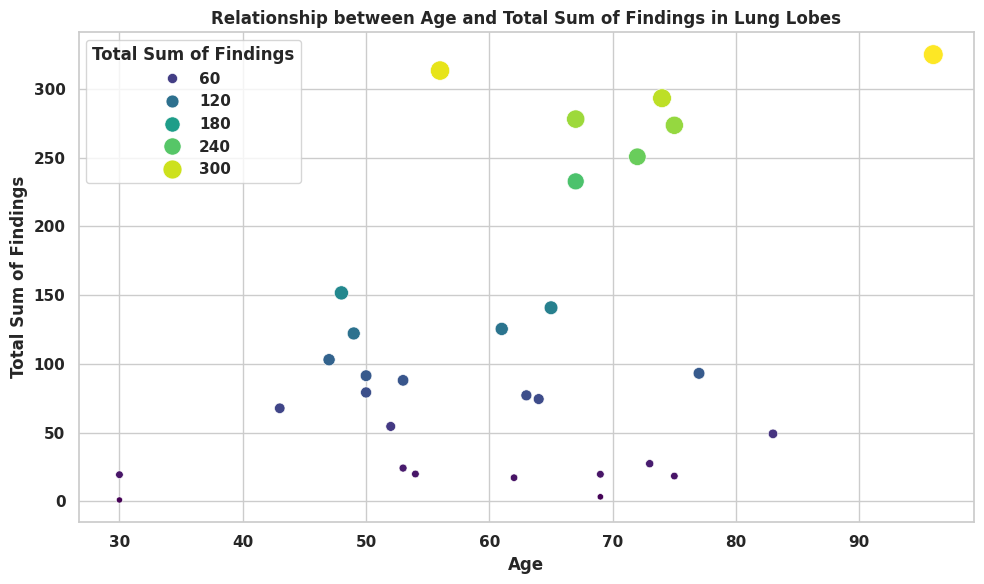

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = result.copy(deep=True)

# Calculating the total sum of findings per patient
df["Total_Findings"] = df[["F_LUL", "F_LLL", "F_RUL", "F_RML", "F_RLL"]].sum(axis=1)

# Setting the style of the chart
sns.set_theme(style="whitegrid")

# Creating the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
	data=df,
	x="Age",
	y="Total_Findings",
	hue="Total_Findings",
	palette="viridis",
	size="Total_Findings",
	sizes=(20, 200),
)
plt.title("Relationship between Age and Total Sum of Findings in Lung Lobes", fontweight='bold')
plt.xlabel("Age", fontweight='bold')
plt.ylabel("Total Sum of Findings", fontweight='bold')
legend = plt.legend(loc="upper left", title="Total Sum of Findings", prop={'weight': 'bold'})
legend.get_title().set_fontweight('bold')

set_bold_properties(plt.gca())
plt.tight_layout()
plt.savefig("images/age_findings.eps", dpi=200, format='eps')
plt.show()

Protocol
HIGH-RESOLUTION THORAX     21
THORAX WITH CONTRAST        4
Routine PE Angiography      3
Whole Aorta Angiography     1
5.3 Chest CTPA              1
Name: count, dtype: int64


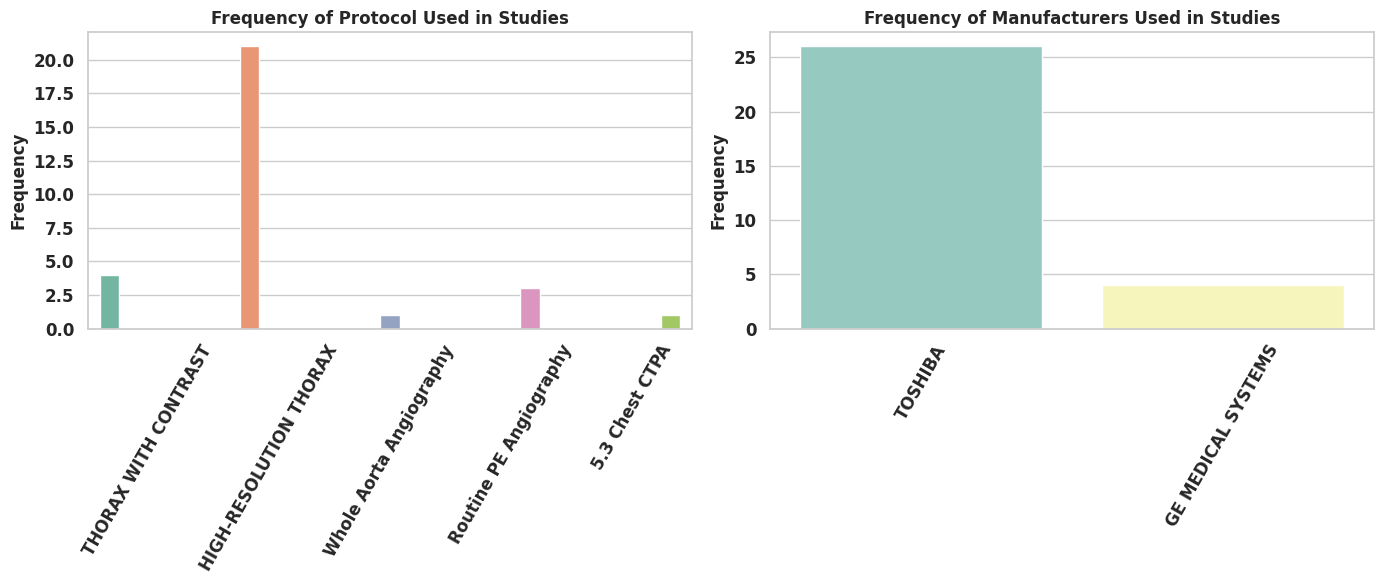

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = result.copy(deep=True)

# Counting the unique values in the column
counting = df['Protocol'].value_counts()
print(counting)

# Setting the chart style
sns.set_theme(style="whitegrid")

# Creating the charts side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for the count of protocols
sns.countplot(data=df, x="Protocol", hue="Protocol", palette="Set2", ax=axes[0], dodge=True)
axes[0].set_title("Frequency of Protocol Used in Studies", fontweight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("Frequency", fontweight='bold')
axes[0].tick_params(axis="x", rotation=60, labelsize=10)

# Setting bold ticks for the second chart
for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
	label.set_fontweight('bold')
	label.set_fontsize(12)

# Bar chart for the count of manufacturers
sns.countplot(data=df, x="Manufacturer", hue="Manufacturer",  palette="Set3", ax=axes[1])
axes[1].set_title("Frequency of Manufacturers Used in Studies", fontweight='bold')
axes[1].set_xlabel("", fontweight='bold')
axes[1].set_ylabel("Frequency", fontweight='bold')
axes[1].tick_params(axis="x", rotation=60)

# Bold tick configuration for the second chart
for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
	label.set_fontweight('bold')
	label.set_fontsize(12)

# Layout adjustment
plt.tight_layout()
plt.savefig("images/protocol_model.eps", dpi=200, format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


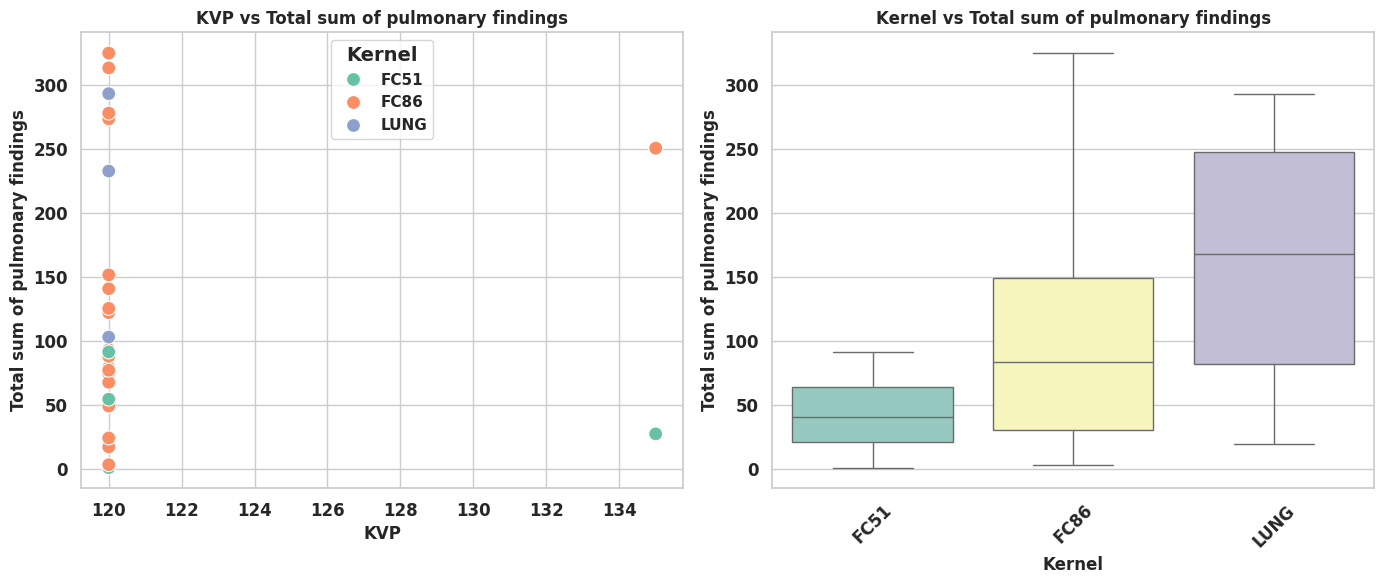

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = result.copy(deep=True)

# Calculating the total sum of findings per patient
df["Total_Findings"] = df[["F_LUL", "F_LLL", "F_RUL", "F_RML", "F_RLL"]].sum(axis=1)

# Setting the chart style
sns.set_theme(style="whitegrid")

# Creating the charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for KVP vs Total_Findings
sns.scatterplot(
	data=df,
	x="KVP",
	y="Total_Findings",
	hue="Kernel",
	palette="Set2",
	s=100,
	ax=axes[0],
)
axes[0].set_title("KVP vs Total sum of pulmonary findings", fontweight='bold')
axes[0].set_xlabel("KVP", fontweight='bold')
axes[0].set_ylabel("Total sum of pulmonary findings", fontweight='bold')

# Adjusting the legend
legend_0 = axes[0].legend(
	title="Kernel",
	title_fontsize=14,
	fontsize=10,
	frameon=True,
	loc='upper center',
	prop={'weight': 'bold'}
)
legend_0.get_title().set_fontweight('bold')

# Bold tick configuration for the first chart
for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
	label.set_fontweight('bold')
	label.set_fontsize(12)

# Boxplot chart for Kernel vs Total_Findings
sns.boxplot(data=df, x="Kernel", y="Total_Findings", hue="Kernel", palette="Set3", ax=axes[1])
axes[1].set_title("Kernel vs Total sum of pulmonary findings", fontweight='bold')
axes[1].set_xlabel("Kernel", fontweight='bold')
axes[1].set_ylabel("Total sum of pulmonary findings", fontweight='bold')
axes[1].tick_params(axis="x", rotation=45)

# Hiding the legend
axes[1].legend([], [], frameon=False)

# Bold tick configuration for the second chart
for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
	label.set_fontweight('bold')
	label.set_fontsize(12)

# Layout adjustment
plt.tight_layout()
plt.savefig("images/kernel_findings.eps", dpi=200, format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


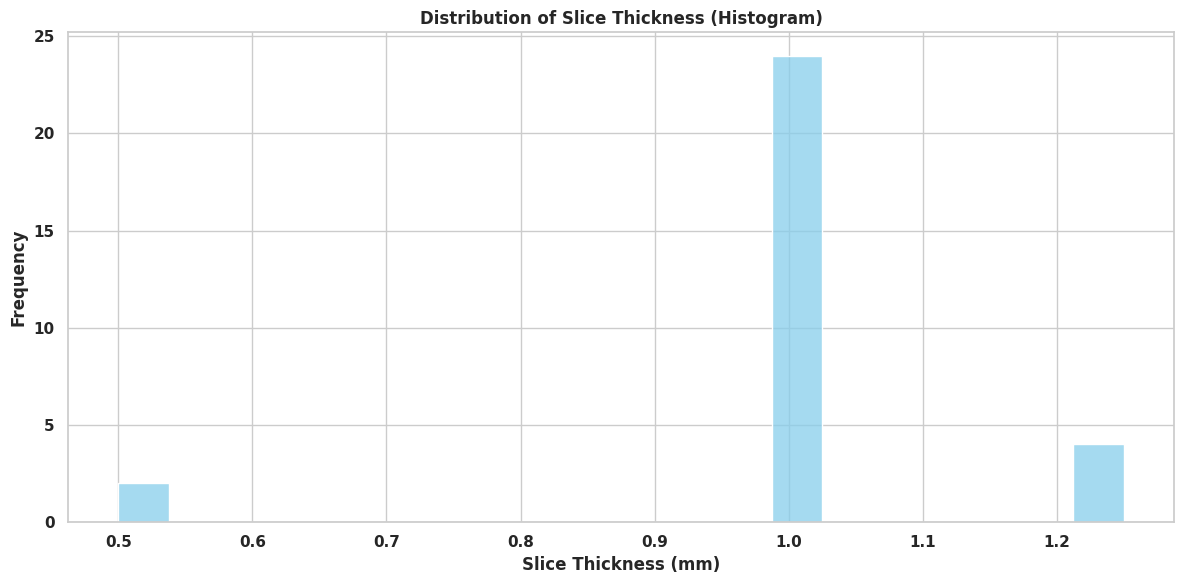

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = result.copy(deep=True)

# Setting the chart style
sns.set_theme(style="whitegrid")

# Histogram for SliceThickness
plt.figure(figsize=(12, 6))
sns.histplot(
	data=df,
	x="SliceThickness",
	kde=False,
	bins=20,
	color="skyblue",
)
plt.title("Distribution of Slice Thickness (Histogram)", fontweight='bold')
plt.xlabel("Slice Thickness (mm)", fontweight='bold')
plt.ylabel("Frequency", fontweight='bold')

set_bold_properties(plt.gca())
plt.tight_layout()
plt.savefig("images/slice_thickness.eps", dpi=200, format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


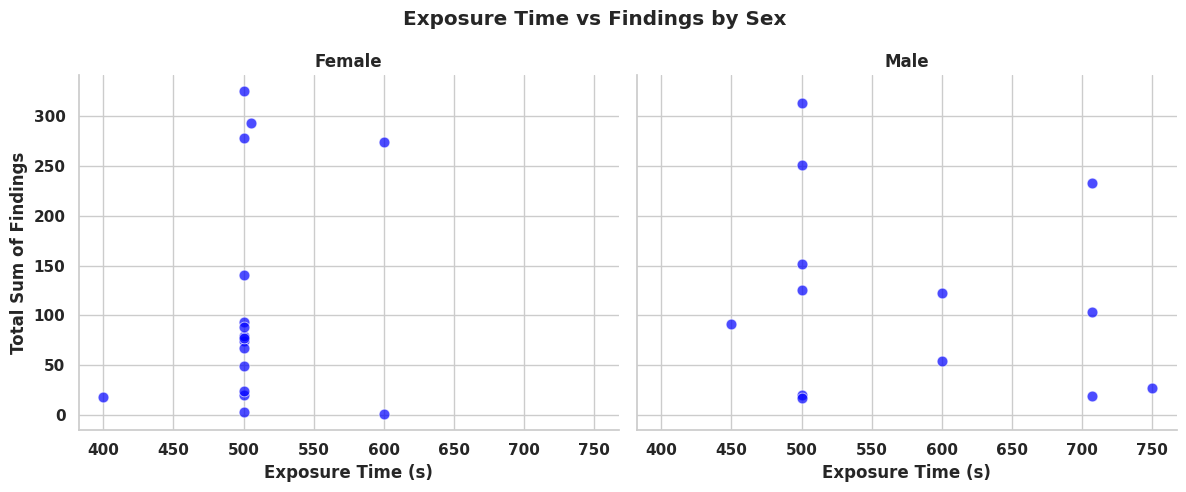

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = result.copy(deep=True)

df['Sex'] = df['Sex'].replace({'F': 'Female', 'M': 'Male'})

# Total sum of findings
df["Total_Findings"] = df[["F_LUL", "F_LLL", "F_RUL", "F_RML", "F_RLL"]].sum(axis=1)

# Categorize age into age groups
df["Age_Group"] = pd.cut(df["Age"], bins=[20, 30, 40, 50, 60, 70, 80],
						 labels=["20-29", "30-39", "40-49", "50-59", "60-69", "70-79"])

# Configuring chart style
sns.set(style="whitegrid")

# Scatter plots separated by sex
g = sns.FacetGrid(df, col="Sex", height=5, aspect=1.2)
g.map(sns.scatterplot, "ExposureTime", "Total_Findings", alpha=0.7, s=60, color="blue")
g.set_axis_labels("Exposure Time (s)", "Total Sum of Findings", fontweight='bold')
g.set_titles("{col_name}", fontweight='bold')
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Exposure Time vs Findings by Sex", fontweight='bold')

# Bold ticks
for ax in g.axes.flat:
	plt.setp(ax.get_xticklabels(), fontweight='bold')
	plt.setp(ax.get_yticklabels(), fontweight='bold')

plt.savefig("images/exposureTime_sex.eps", dpi=200, format='eps')
plt.show()

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

result = df_sorted.copy(deep=True)

result.rename(columns={'LUL': 'F_LUL'}, inplace=True)
result.rename(columns={'LLL': 'F_LLL'}, inplace=True)
result.rename(columns={'RUL': 'F_RUL'}, inplace=True)
result.rename(columns={'RML': 'F_RML'}, inplace=True)
result.rename(columns={'RLL': 'F_RLL'}, inplace=True)
result.rename(columns={'ID Image': 'ID'}, inplace=True)

result['ID'] = result['ID'].astype(str)

result['F_LUL'] = result['F_LUL'].astype(float)
result['F_LLL'] = result['F_LLL'].astype(float)
result['F_RUL'] = result['F_RUL'].astype(float)
result['F_RML'] = result['F_RML'].astype(float)
result['F_RLL'] = result['F_RLL'].astype(float)

result['SliceThickness'] = result['SliceThickness'].astype(float)

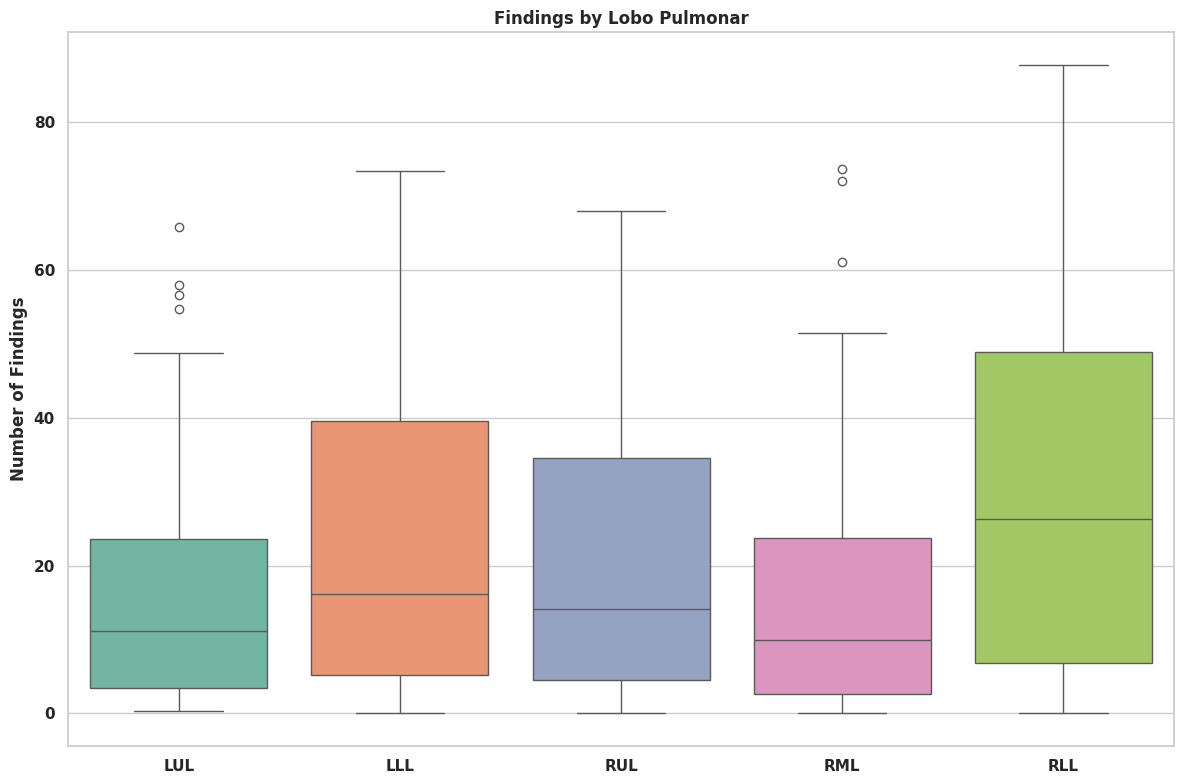

In [29]:
df = result.copy(deep=True)

lobes = ["LUL", "LLL", "RUL", "RML", "RLL"]

df.rename(columns={'F_LUL': 'LUL'}, inplace=True)
df.rename(columns={'F_LLL': 'LLL'}, inplace=True)
df.rename(columns={'F_RUL': 'RUL'}, inplace=True)
df.rename(columns={'F_RML': 'RML'}, inplace=True)
df.rename(columns={'F_RLL': 'RLL'}, inplace=True)

# Configuring chart style
sns.set_theme(style="whitegrid")

# Chart: Boxplot for each lung lobe
plt.figure(figsize=(12, 8))
df_melted = df.melt(value_vars=lobes, var_name="Lobo", value_name="Findings")
sns.boxplot(data=df_melted, x="Lobo", y="Findings", hue='Lobo', palette="Set2")
plt.title("Findings by Lobo Pulmonar", fontweight='bold')
plt.xlabel("", fontweight='bold')
plt.ylabel("Number of Findings", fontweight='bold')

set_bold_properties(plt.gca())
plt.tight_layout()
plt.savefig("images/findings_per_lobe4.eps", dpi=200, format='eps')
plt.show()

/tmp/ipykernel_555298/188065843.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df_long.groupby(['Lobo', 'CategoryScore'])['Findings'].mean().reset_index()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


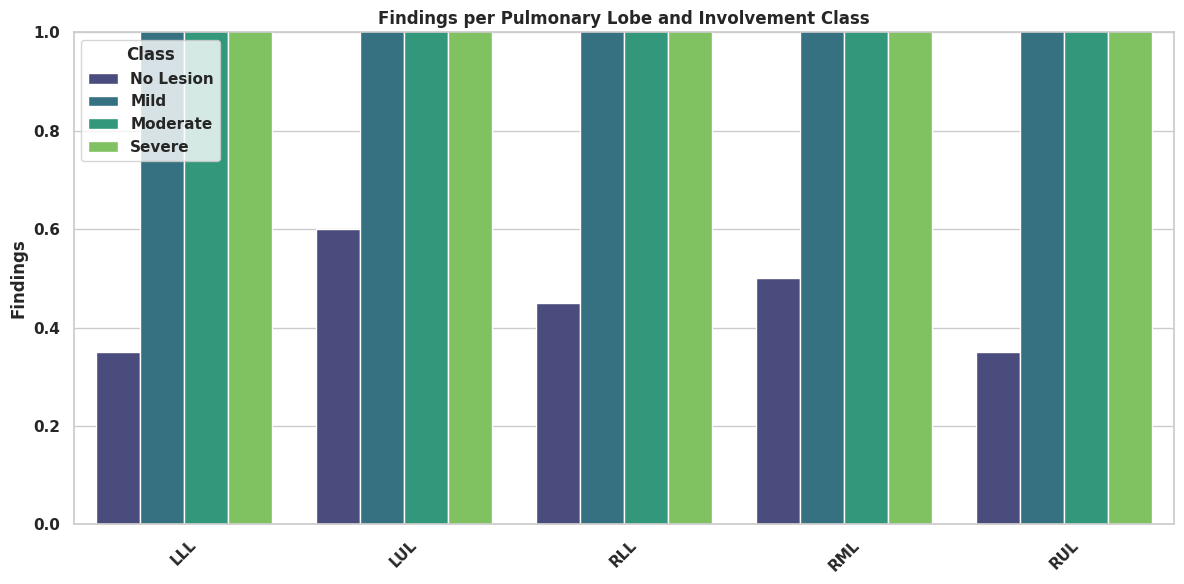

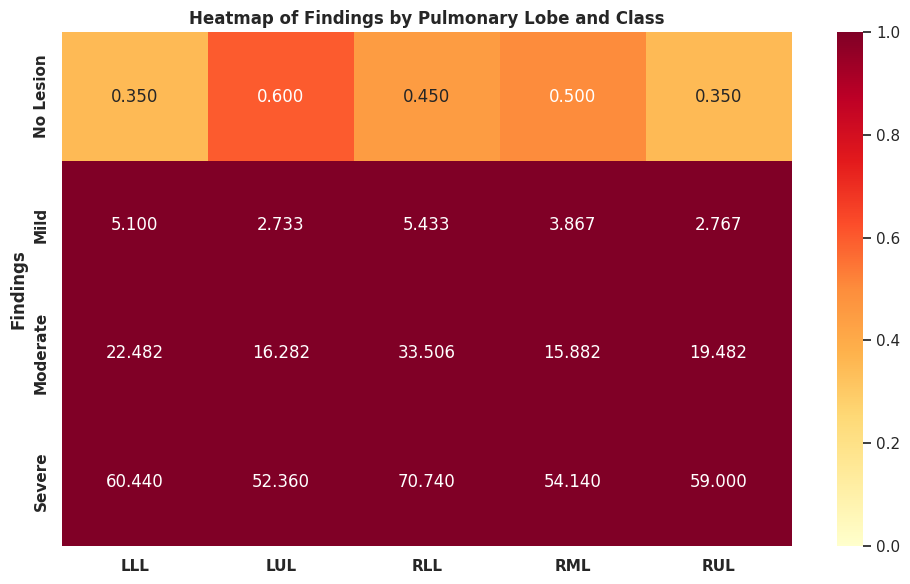

In [30]:
# Creating the 'Findings' column from the columns LUL, LLL, RUL, RML, RLL
df_long = pd.melt(df, id_vars=['ID', 'CategoryScore'], value_vars=['LUL', 'LLL', 'RUL', 'RML', 'RLL'], var_name='Lobo', value_name='Findings')

df_long['Findings'] = df_long['Findings'].astype(float)

df_long = pd.DataFrame(df_long)

# Calculating the means by lobe and class
df_mean = df_long.groupby(['Lobo', 'CategoryScore'])['Findings'].mean().reset_index()

# 1. Grouped Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(data=df_mean, x='Lobo', y='Findings', hue='CategoryScore', palette='viridis')
plt.title('Findings per Pulmonary Lobe and Involvement Class', fontweight='bold')
plt.xlabel('', fontweight='bold')
plt.ylabel('Findings', fontweight='bold')
legend = plt.legend(title='Class')
plt.setp(legend.get_title(), fontweight='bold')
plt.setp(legend.get_texts(), fontweight='bold')
plt.xticks(rotation=45)
set_bold_properties(plt.gca())
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("images/findings_score.eps", dpi=200, format='eps')
plt.show()

# 3. Heatmap
pivot_table = df_mean.pivot(index='CategoryScore', columns='Lobo', values='Findings')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', vmin=0, vmax=1)
plt.title('Heatmap of Findings by Pulmonary Lobe and Class', fontweight='bold')
plt.xlabel('', fontweight='bold')
plt.ylabel('Findings', fontweight='bold')
set_bold_properties(plt.gca())
plt.setp(legend.get_title(), fontweight='bold')
plt.setp(legend.get_texts(), fontweight='bold')
plt.tight_layout()
plt.savefig("images/findings_score2.eps", dpi=200, format='eps')
plt.show()

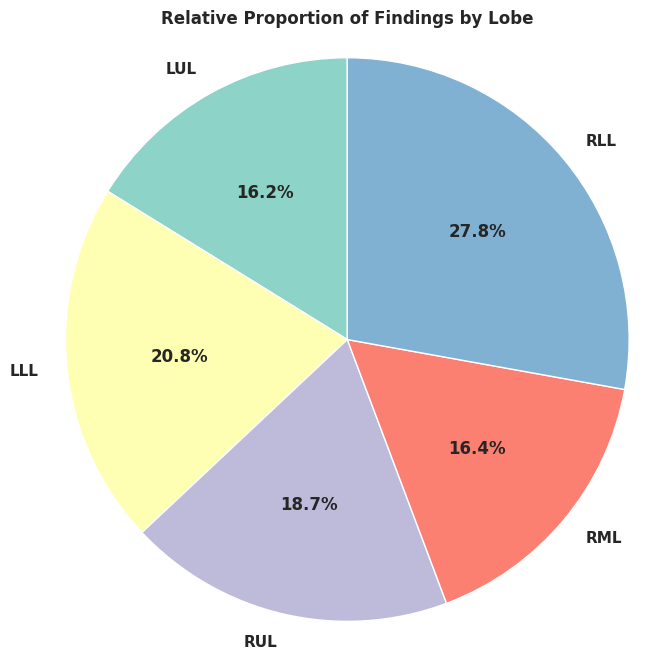

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


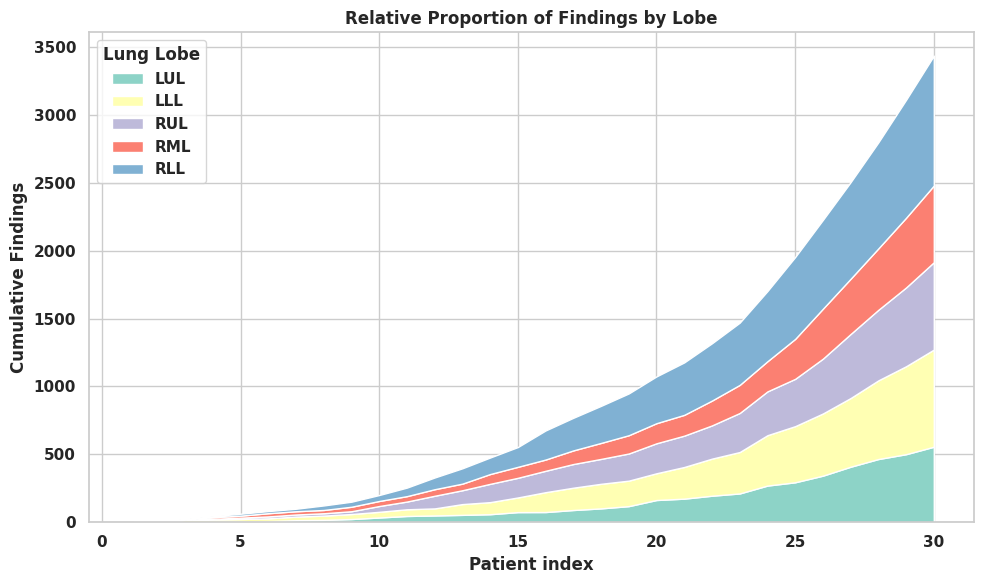

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = result.copy(deep=True)

# Calculating the total sum of findings per lobe
lobes = ["F_LUL", "F_LLL", "F_RUL", "F_RML", "F_RLL"]
total_findings_per_lobe = df[lobes].sum()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
	total_findings_per_lobe,
	labels=["LUL", "LLL", "RUL", "RML", "RLL"],
	autopct="%1.1f%%",
	colors=plt.cm.Set3.colors,
	startangle=90,
	textprops={'fontweight': 'bold'}
)
plt.title("Relative Proportion of Findings by Lobe", fontweight='bold')
plt.axis("equal")
plt.savefig("images/findings_per_lobe2.eps", dpi=200, format='eps')
plt.show()

# Stacked area chart
df_cumsum = df[lobes].cumsum()

plt.figure(figsize=(10, 6))
plt.stackplot(
	range(1, len(df_cumsum) + 1),
	df_cumsum.T,
	labels=["LUL", "LLL", "RUL", "RML", "RLL"],
	colors=plt.cm.Set3.colors,
)
plt.title("Relative Proportion of Findings by Lobe", fontweight='bold')
plt.xlabel("Patient index", fontweight='bold')
plt.ylabel("Cumulative Findings", fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
legend = plt.legend(loc="upper left", title="Lung Lobe", prop={'weight': 'bold'})
legend.get_title().set_fontweight('bold')
plt.tight_layout()
plt.savefig("images/findings_per_lobe3.eps", dpi=200, format='eps')
plt.show()

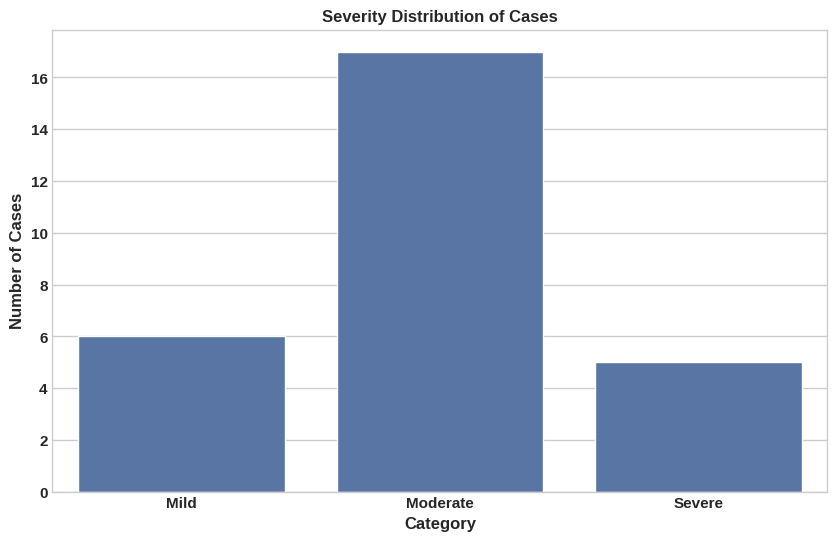

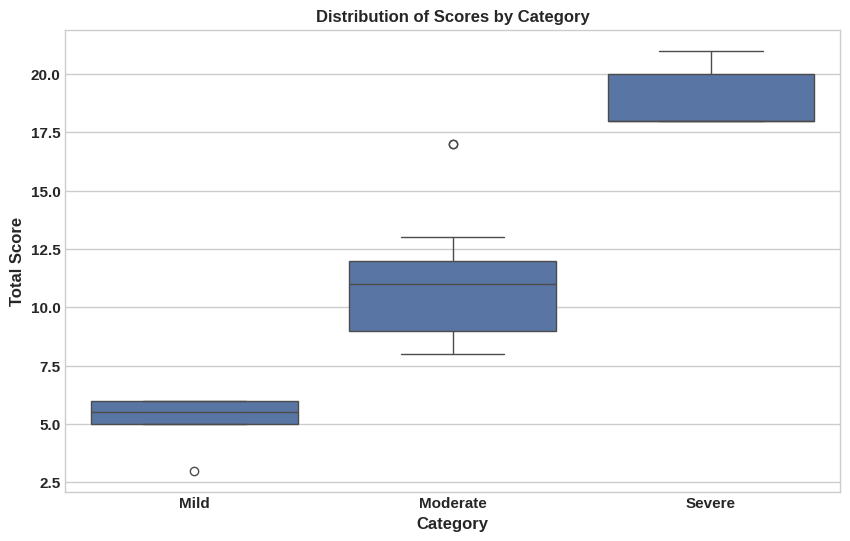

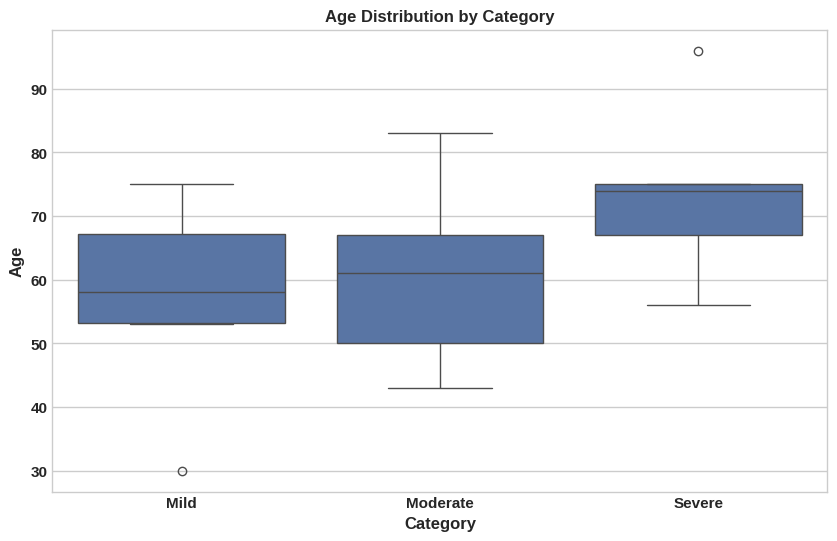

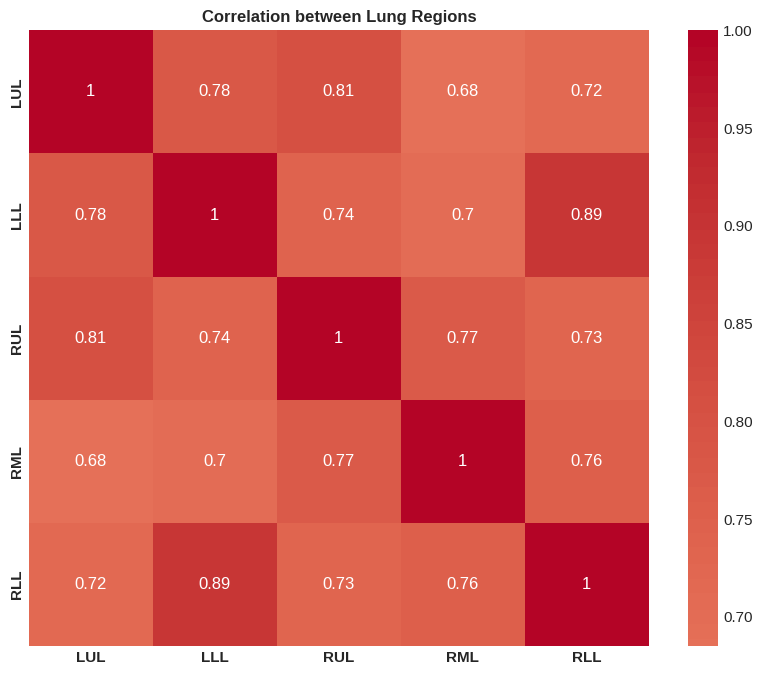

<Figure size 1000x600 with 0 Axes>

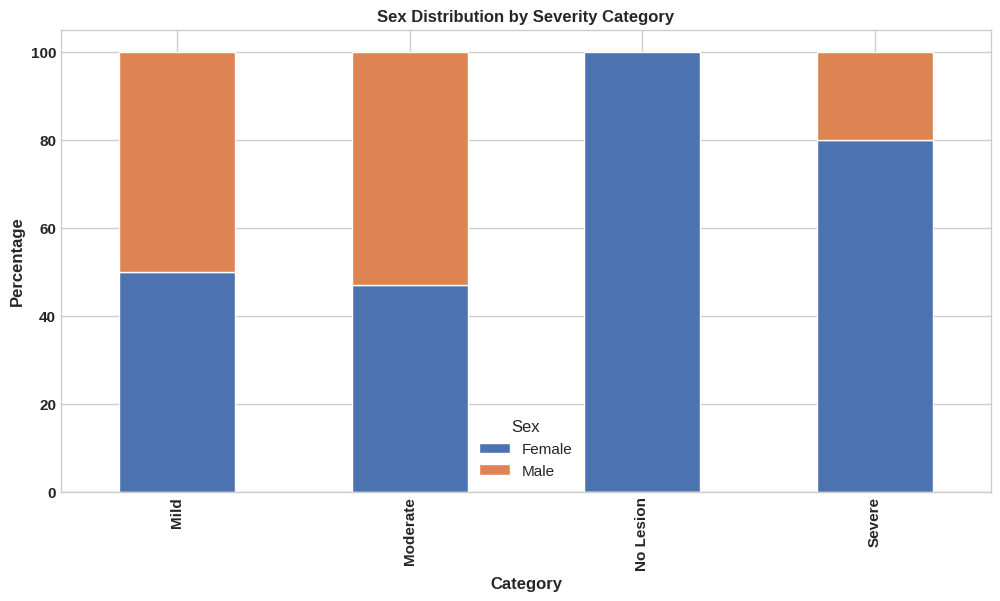

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path_dados = os.path.join('output_HCU/dicom_headers_COVIDS_final.csv')

# Reading the data and removing empty rows
df = pd.read_csv(path_dados)
df = df.dropna(subset=['CategoryScore'])

# Setting the chart style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Distribution of severity categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='CategoryScore', order=['Mild', 'Moderate', 'Severe'])
plt.title('Severity Distribution of Cases', fontweight='bold')
plt.xlabel('Category', fontweight='bold')
plt.ylabel('Number of Cases', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

# 2. Box plot of scores by category
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='CategoryScore', y='Score', order=['Mild', 'Moderate', 'Severe'])
plt.title('Distribution of Scores by Category', fontweight='bold')
plt.xlabel('Category', fontweight='bold')
plt.ylabel('Total Score', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

# 3. Distribution by age and severity
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='CategoryScore', y='Age', order=['Mild', 'Moderate', 'Severe'])
plt.title('Age Distribution by Category', fontweight='bold')
plt.xlabel('Category', fontweight='bold')
plt.ylabel('Age', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

# 4. Heatmap of correlations between lung regions
regions = ['LUL', 'LLL', 'RUL', 'RML', 'RLL']
correlation_matrix = df[regions].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Lung Regions', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

# 5. Distribution by sex and severity
plt.figure(figsize=(10, 6))
severity_sex = pd.crosstab(df['CategoryScore'], df['Sex'], normalize='index') * 100
severity_sex.plot(kind='bar', stacked=True)
plt.title('Sex Distribution by Severity Category', fontweight='bold')
plt.xlabel('Category', fontweight='bold')
plt.ylabel('Percentage', fontweight='bold')
plt.legend(title='Sex')
set_bold_properties(plt.gca())
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

In [33]:
import os
import pandas as pd

# Read the data (assuming it is already loaded in a DataFrame)
path_dados = os.path.join('output_HCU/dicom_headers_COVIDS_final.csv')

df = pd.read_csv(path_dados)

output_dir = 'output_HCU'
filenames = 'Kernel', 'KVP', 'Manufacturer', 'Model', 'Protocol', 'SliceThickness', 'Age', 'Sex'

os.makedirs(output_dir, exist_ok=True)

for filename in filenames:
	file_path = os.path.join(output_dir, filename+'.csv')
	df_sorted = df.sort_values(by=filename)
	df_sorted.to_csv(file_path, index=False)

	print(f"Table saved in: {file_path}")

Table saved in: output_HCU/Kernel.csv
Table saved in: output_HCU/KVP.csv
Table saved in: output_HCU/Manufacturer.csv
Table saved in: output_HCU/Model.csv
Table saved in: output_HCU/Protocol.csv
Table saved in: output_HCU/SliceThickness.csv
Table saved in: output_HCU/Age.csv
Table saved in: output_HCU/Sex.csv
